# Statistical Analysis of fMRI Data

This section covers the fundamentals of statistical analysis in fMRI data, including creating a design matrix, fitting a general linear model (GLM), contrasts, and multiple comparison corrections.

In [19]:
# Import all required libraries
from bids import BIDSLayout
from nilearn import image
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.glm.first_level.hemodynamic_models import glover_hrf
from nilearn.plotting import plot_anat, show, plot_design_matrix

import pandas as pd
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

## Introducing BIDS
The Brain Imaging Data Structure (BIDS) is a standardized way to organize and describe neuroimaging data. It simplifies data sharing and analysis by providing a consistent structure. In this example, we will use a BIDS-formatted dataset to demonstrate fMRI data analysis. 


## Read the BIDS Structure

First, we need to read the BIDS structure to access our fMRI data. We'll use the `bids` library for this purpose.


In [3]:
# Initialize BIDS layout (validate=False skips full validation for speed)
layout = BIDSLayout('./data/BIDS', validate=False)

# Display dataset info
print(f"Dataset: {layout.description['Name']}")
print(f"Subjects: {layout.get_subjects()}")
print(f"Tasks: {layout.get_tasks()}")
print(f"Sessions: {layout.get_sessions()}")

Dataset: Visual Motion Localizer fMRI Dataset
Subjects: ['001']
Tasks: ['MotionLoc']
Sessions: ['01']


## Read the fMRI Data

Next, we will read the fMRI data from the BIDS structure. We will use the `nibabel` library to load the NIfTI files. 

```python

In [4]:
# Get functional BOLD data for subject 001
bold_file = layout.get(subject='001', session='01', task='MotionLoc',
                       suffix='bold', extension='.nii.gz')[0]

# Get events file
events_file = layout.get(subject='001', session='01', task='MotionLoc',
                        suffix='events', extension='.tsv')[0]

# Load the BOLD data
bold_img = image.load_img(bold_file.path)


## Vizualize the fMRI Data

It's always good to visualize your data and do some other validation checks when you first open an image. This way, you can ensure that the data has been read correctly and is in the expected format.

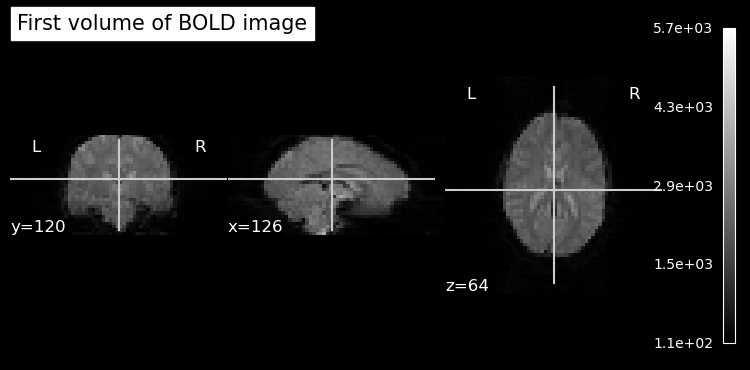

In [5]:
# plot an ortho view of the BOLD image

# Temporarily set figure size to be 25% wider
plt.rcParams['figure.figsize'] = [12.5, 10]
plot_anat(bold_img.slicer[:, :, :, 0], title='First volume of BOLD image')
show()

## Read fMRI Header Information

Nifti files contain header information that provides metadata about the image, such as voxel dimensions, data type, and orientation. We can access this information using the `nibabel` library. 

In [6]:
# show nifti header
print(bold_img.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 48
dim             : [  4  64  64  30 103   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1. 4. 4. 4. 2. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 29
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'')
aux_file        : np.bytes_(b'')
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : -0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0

## View dimensions and voxel size

The Nifti header contains a lot of information. Let's pull out specifically the voxel dimensions, and the number of voxels in each plane of the image. 



In [7]:
# read bold image header using nibabel
# Get voxel dimensions and shape from the BOLD image
voxel_dimensions = bold_img.header.get_zooms()
num_voxels = bold_img.header.get_data_shape()

print(f"Voxel Dimensions: {voxel_dimensions[0]:.1f} x {voxel_dimensions[1]:.1f} x {voxel_dimensions[2]:.1f} mm")
print(f"TR: {voxel_dimensions[3]:.1f} seconds")
print(f"Number of Voxels in each plane: {num_voxels}")

Voxel Dimensions: 4.0 x 4.0 x 4.0 mm
TR: 2.0 seconds
Number of Voxels in each plane: (64, 64, 30, 103)


You'll notice in the output that the fourth dimension corresponds to the TR (repetition time) of the fMRI scan, which is the time between successive volume acquisitions. This is important for understanding the temporal resolution of your fMRI data. It also explains why fMRI data is often represented as a 4D dataset, with three spatial dimensions and one temporal dimension. In the output above, the 4th value listed in the "Number of Voxels in each plane" corresponds to the number of time points (or volumes) acquired during the fMRI scan.

## Load Structural (Anatomical) Image

In [8]:
# load anatomical image
anat_file = layout.get(subject='001', session='01',
                      suffix='T1w', extension='.nii.gz')[0]
anat_img = image.load_img(anat_file.path)
print(f"Anatomical image shape: {anat_img.shape}")

voxel_dims = anat_img.header.get_zooms()
print(f"Voxel Dimensions: {voxel_dims[0]:.1f} x {voxel_dims[1]:.1f} x {voxel_dims[2]:.1f} mm")

Anatomical image shape: (160, 256, 256)
Voxel Dimensions: 1.0 x 1.0 x 1.0 mm


Since the anatomical image is strrctural, there is only one volume so it's a 3D image with no time dimension. You'll also notice that the voxel dimensions are different between the anatomical and functional images. Anatomical images typically have higher spatial resolution than functional images. Since the voxels are smaller, more of them are required to cover the same brain volume. 

## Plot Anatomical Image

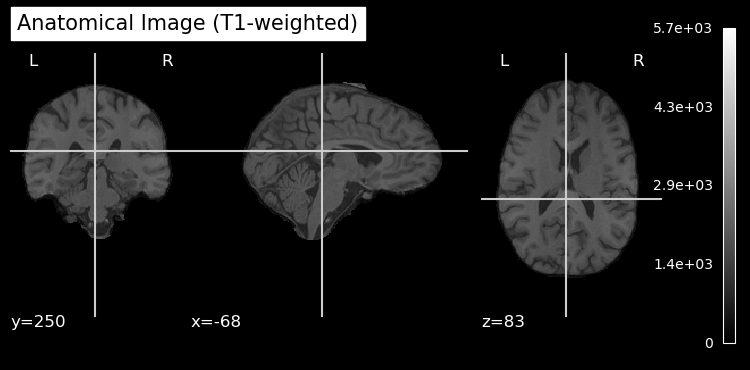

In [9]:
# plot anatomical image
plt.rcParams['figure.figsize'] = [12.5, 10]
plot_anat(anat_img, title='Anatomical Image (T1-weighted)')
show()

Note that the anatomical image has been *skull stripped* to remove non-brain tissue. This is a common preprocessing step in neuroimaging to focus analyses on brain tissue only. It also helps anonymize the data by removing identifiable features such as the face and skull.

## Read Events File

The events file contains information about the timing and type of stimuli presented during the fMRI scan. We will read this file using `pandas`.

In [10]:
# Load events as DataFrame
events_df = pd.read_csv(events_file.path, sep='\t')

print(f"\nEvents (first few rows):")
print(events_df.head())


Events (first few rows):
   onset  duration trial_type
0    6.0      20.0     motion
1   46.0      20.0     motion
2   86.0      20.0     motion
3  126.0      20.0     motion
4  166.0      20.0     motion


This shows us that there is only one type of event: `motion`. In this block design, blocks of moving dot stimuli alternatied with blocks of static dot stimuli. However, since there are only two conditions (motion and static), we can model the static condition as the baseline (intercept) in our design matrix. This means we don't need to explicitly include it as a separate regressor in our model; rather, the baseline is inferred from the absence of any explicitly-defined event occurring at a given time point.

## The Design Matrix

The design matrix represents the experimental conditions and is used in the GLM analysis. At first it may seem confusing, but it's essentially a way to encode when different stimuli were presented during the fMRI scan. This is used in the statistical analysis to essentially perform a correlation (regression) between the BOLD time series at each voxel in the image, and the time series that would be predicted for brain areas that are sensitive to the experimental conditions. 

In our simple moving/not moving block design, this means we want to correlate the data at each voxel with a time series that is high during blocks of moving dots, and low during blocks of static dots. This is often called a boxcar design. Let's draw this boxcar design using matplotlib and the event timings in `events_df`:

:::{admonition} Hidden code
The code that generates this plot (and a few after it) is hidden to reduce clutter. The focus of this lesson is on GLM analysis, not how to generate these plots.
:::

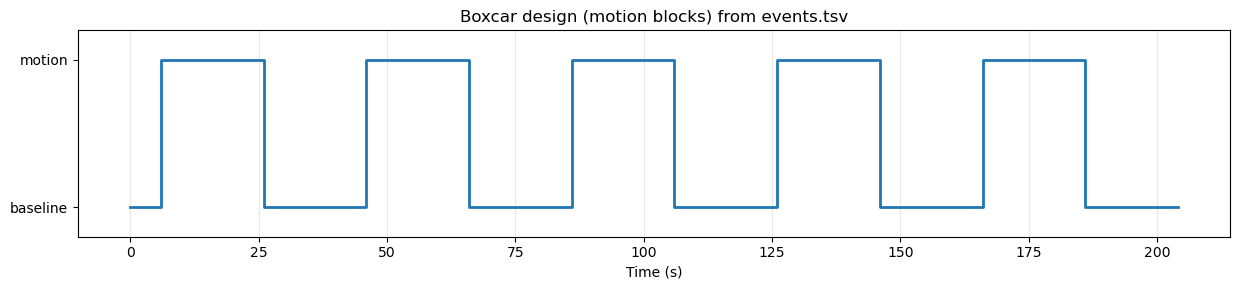

In [11]:
# Create and plot a boxcar (square-wave) design from events_df

# Derive timing grid from the BOLD image
tr_sec = float(bold_img.header.get_zooms()[3])  # seconds per volume
n_scans = int(bold_img.shape[-1])
frame_times = np.arange(n_scans) * tr_sec

# Build a binary regressor that's 1 during motion blocks, 0 otherwise
boxcar = np.zeros_like(frame_times, dtype=float)
for _, row in events_df.iterrows():
    onset = float(row['onset'])
    duration = float(row['duration'])
    # Mark frames whose time falls within the event window
    idx = (frame_times >= onset) & (frame_times < onset + duration)
    boxcar[idx] = 1.0

# Plot as a step function (square wave)
plt.figure(figsize=(12.5, 3.0))
plt.step(frame_times, boxcar, where='post', linewidth=2)
plt.ylim(-0.2, 1.2)
plt.yticks([0, 1], ['baseline', 'motion'])
plt.xlabel('Time (s)')
plt.title('Boxcar design (motion blocks) from events.tsv')
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()

### Modelling the Hemodynamic Response Function (HRF)

Although our experimental design is a simple boxcar design, the BOLD response in the brain does not follow this boxcar shape exactly. Instead, the BOLD response is delayed and smoothed due to the hemodynamic response function (HRF), which describes how blood flow changes in response to neural activity. There are several models of the HRF, but a common one is the `glover` model, originally described by Gary Glover in 1999. This model posits that the HRF in response to a transient (short) neural event can be described by a relatively simple mathematical function that captures the key features of the BOLD response, including its initial rise, peak, and subsequent undershoot. If we plot the Glover HRF it looks like this:


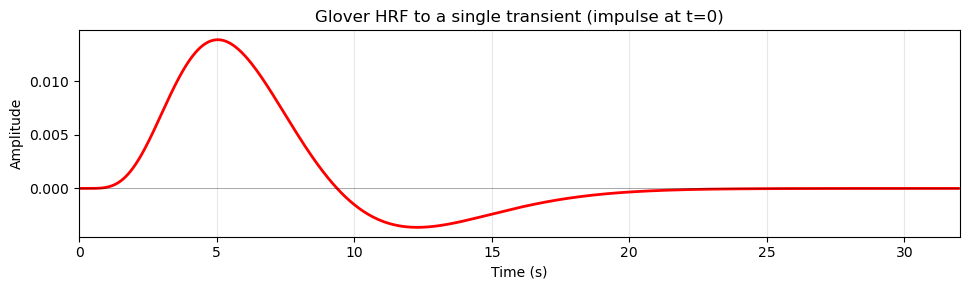

In [12]:
# Plot the Glover HRF response to a single transient (impulse at t=0)

# Use TR from the functional image
tr_sec = float(bold_img.header.get_zooms()[3])

# High-resolution HRF sampling
oversampling = 50
time_length = 32.0  # seconds

# Updated parameter name: use t_r instead of deprecated tr
hrf = glover_hrf(t_r=tr_sec, oversampling=oversampling, time_length=time_length, onset=0)

dt = tr_sec / oversampling
t = np.arange(0, time_length, dt)

plt.figure(figsize=(10, 3))
plt.plot(t, hrf, color='red', linewidth=2)
plt.axhline(0, color='k', linewidth=0.6, alpha=0.4)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Glover HRF to a single transient (impulse at t=0)')
plt.xlim(0, time_length)
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

Note that the HRF does not start right at time zero (when the stimulus occurred), but has a delay of about 2 seconds before it starts to rise. This delay reflects the time it takes for capillaries to dilate in response to changes in nneural activity, and allow more blood to flow to the area. The HRF peaks around 5-6 seconds after the neural event and then gradually returns to baseline, often dipping below baseline (undershoot) before stabilizing.

Because of this delayed and smoothed response, we cannot simply use the boxcar design as our regressor in the GLM analysis. Technically we could, but the correlation to the actual BOLD response would be much weaker, since the BOLD response does not follow the boxcar shape exactly. Instead, we need to account for the HRF when creating our design matrix. We do this using a mathematical operation called convolution. Convolution essentially "smears" the boxcar design by the shape of the HRF (imagine the HRF shown above sliding in time from left to right over the boxcar plot), resulting in a regressor that more closely matches the expected BOLD response to the stimuli.


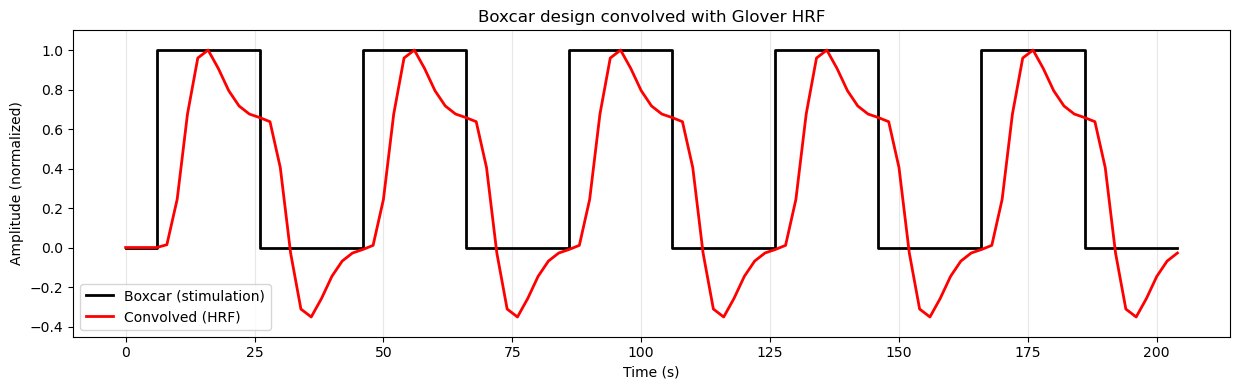

In [13]:
# Convolve boxcar design with Glover HRF and plot

# Recreate frame_times and boxcar (reuse variables if they exist)
tr_sec = float(bold_img.header.get_zooms()[3])
n_scans = int(bold_img.shape[-1])
frame_times = np.arange(n_scans) * tr_sec

if 'boxcar' not in globals():
    boxcar = np.zeros_like(frame_times, dtype=float)
    for _, row in events_df.iterrows():
        onset = float(row['onset'])
        duration = float(row['duration'])
        idx = (frame_times >= onset) & (frame_times < onset + duration)
        boxcar[idx] = 1.0

# Oversampled time grid for more accurate convolution
oversampling = 50
time_length = frame_times[-1] + tr_sec  # cover full duration
hrf = glover_hrf(t_r=tr_sec, oversampling=oversampling, time_length=32.0, onset=0)

# Build an oversampled neural (boxcar) vector
dt = tr_sec / oversampling
high_res_time = np.arange(0, time_length, dt)
high_res_neural = np.zeros_like(high_res_time)
for _, row in events_df.iterrows():
    onset = float(row['onset'])
    duration = float(row['duration'])
    idx = (high_res_time >= onset) & (high_res_time < onset + duration)
    high_res_neural[idx] = 1.0

# Convolve and trim
conv_high_res = np.convolve(high_res_neural, hrf)[:high_res_neural.size]

# Downsample back to scan times
conv_regressor = []
for t in frame_times:
    # pick closest high-res index
    idx = int(round(t / dt))
    if idx >= conv_high_res.size:
        idx = conv_high_res.size - 1
    conv_regressor.append(conv_high_res[idx])
conv_regressor = np.array(conv_regressor)

# Normalize for visual comparison (optional)
if conv_regressor.max() > 0:
    conv_norm = conv_regressor / conv_regressor.max()
else:
    conv_norm = conv_regressor

plt.figure(figsize=(12.5, 4))
plt.step(frame_times, boxcar, where='post', label='Boxcar (stimulation)', linewidth=2, color='black')
plt.plot(frame_times, conv_norm, label='Convolved (HRF)', linewidth=2, color='red')

# Dynamic y-limits so negative undershoot isn't cropped
ymin = min(conv_norm.min(), boxcar.min()) - 0.1
ymax = max(conv_norm.max(), boxcar.max()) + 0.1
plt.ylim(ymin, ymax)

plt.xlabel('Time (s)')
plt.ylabel('Amplitude (normalized)')
plt.title('Boxcar design convolved with Glover HRF')
plt.legend(loc='lower left')
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Regressors in the Design Matrix

### Experimental Regressors
Whe we create the desgn matrix, we use the HRF model to convolve our time series this way. In this simple example, we only have one condition (motion), so our design matrix will have one regressor for the motion condition. However, in a more complex design with multiple conditions, we would have multiple regressors (time series), one for each condition.

### Nuisance Regressors
The design matrix also includes other regressors, such as an intercept term (constant) to model the baseline signal, and potentially other nuisance regressors to account for confounding factors.

 The intercept is necessary because the general linear model (GLM), which we use to analyze fMRI data, is an extension of the simple formula for a line that you likely learned in school: `y = mx + b`. In this formula, 'b' represents the y-intercept, which is the value of 'y' when 'x' is zero. In the context of fMRI data analysis, the intercept represents the baseline level of the BOLD signal when no experimental conditions are present (or in this case, when the dots on the screen were not moving).

In addition to the intercept, we often include other *nuisance regressors* in the design matrix to account for confounding factors that can influence the BOLD signal but are not of primary interest in our analysis. BOLD data is known to contain drift (meaning that the signal can slowly change over time) due to scanner instability or physiological factors. It may also contain low-frequency (slowly changing over time) noise due to physilogical processes such as respiration and heart rate. To account for these confounding factors, we can include nuisance regressors in our design matrix that model these effects. The simplest way to do this is to include polynomial trends (e.g., linear, quadratic) to model drift, and potentially other regressors derived from physiological recordings (if available) to model physiological noise.

Other examples of nuisance regressors include motion parameters (to account for head movement during the scan), and physiological signals (e.g., heart rate, respiration if they were recorded along with the fMRI data). Including these nuisance regressors helps to improve the accuracy and reliability of our statistical analysis by reducing the influence of these confounding factors on the estimated effects of our experimental conditions. However, in the present example we will keep it simple and only include the intercept and polynomial terms.

All of the regressors in our design matrix look like this:


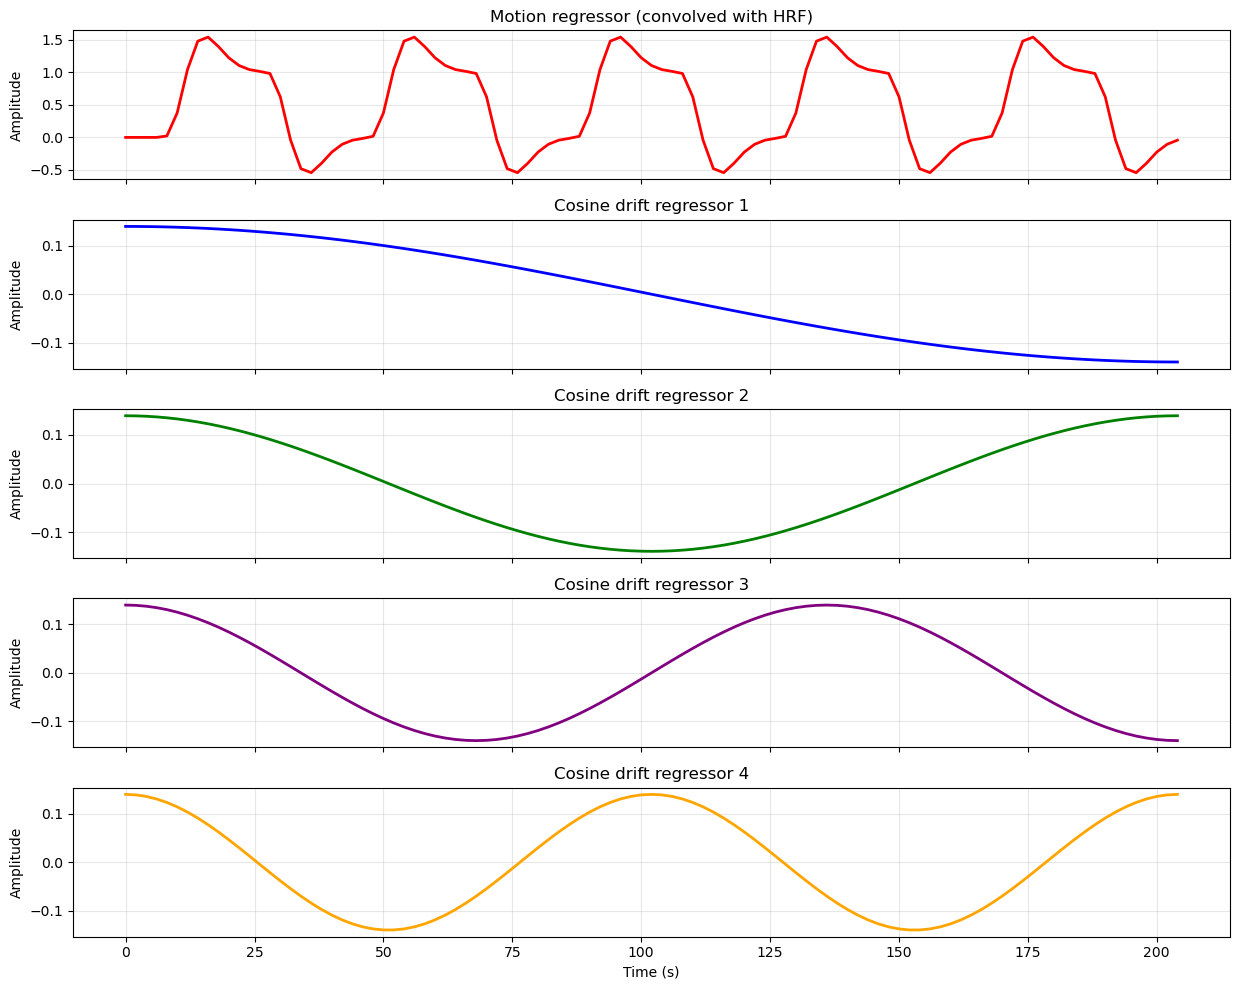

In [20]:
# Plot example regressors that would be in a design matrix

# Recreate frame_times if needed
tr_sec = float(bold_img.header.get_zooms()[3])
n_scans = int(bold_img.shape[-1])
frame_times = np.arange(n_scans) * tr_sec

# Generate the motion regressor by convolving boxcar with HRF
# (same approach as earlier cell)
if 'boxcar' not in globals():
    boxcar = np.zeros_like(frame_times, dtype=float)
    for _, row in events_df.iterrows():
        onset = float(row['onset'])
        duration = float(row['duration'])
        idx = (frame_times >= onset) & (frame_times < onset + duration)
        boxcar[idx] = 1.0

# Oversampled convolution
oversampling = 50
time_length = frame_times[-1] + tr_sec
hrf = glover_hrf(t_r=tr_sec, oversampling=oversampling, time_length=32.0, onset=0)

dt = tr_sec / oversampling
high_res_time = np.arange(0, time_length, dt)
high_res_neural = np.zeros_like(high_res_time)
for _, row in events_df.iterrows():
    onset = float(row['onset'])
    duration = float(row['duration'])
    idx = (high_res_time >= onset) & (high_res_time < onset + duration)
    high_res_neural[idx] = 1.0

conv_high_res = np.convolve(high_res_neural, hrf)[:high_res_neural.size]

# Downsample to scan times
motion_regressor = []
for t in frame_times:
    idx = int(round(t / dt))
    if idx >= conv_high_res.size:
        idx = conv_high_res.size - 1
    motion_regressor.append(conv_high_res[idx])
motion_regressor = np.array(motion_regressor)

# Create cosine drift regressors manually
# High-pass filter at 0.01 Hz (matching the design matrix creation)
high_pass = 0.01

# Calculate number of cosine basis functions based on high-pass frequency
# This matches nilearn's approach
n_times = len(frame_times)
duration = frame_times[-1]
order = int(np.floor(2 * duration * high_pass))

# Generate cosine basis functions
cosine_drift = np.zeros((n_times, order))
normalizer = np.sqrt(2.0 / n_times)

for k in range(order):
    cosine_drift[:, k] = normalizer * np.cos((np.pi / duration) * (k + 1) * (frame_times - frame_times[0]))

# Get first 4 cosine basis functions
n_cosines = min(4, cosine_drift.shape[1])

# Create figure with subplots (motion + cosine basis functions)
fig, axes = plt.subplots(n_cosines + 1, 1, figsize=(12.5, 10), sharex=True)

# Colors for each regressor
colors = ['red', 'blue', 'green', 'purple', 'orange']

# Plot 1: Motion regressor (convolved with HRF)
axes[0].plot(frame_times, motion_regressor, color=colors[0], linewidth=2)
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Motion regressor (convolved with HRF)')
axes[0].grid(True, alpha=0.3)

# Plot cosine basis functions
for i in range(n_cosines):
    axes[i+1].plot(frame_times, cosine_drift[:, i], color=colors[i+1], linewidth=2)
    axes[i+1].set_ylabel('Amplitude')
    axes[i+1].set_title(f'Cosine drift regressor {i+1}')
    axes[i+1].grid(True, alpha=0.3)

axes[-1].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

### Create the Design Matrix

In practice, we don't need to generate all of the plots above or write code to implement any of the computations used to create them. This is all done by `nilearn`'s `make_first_level_design_matrix` function. 

This function requires a number of inputs: the frame times (time points corresponding to each volume in the fMRI data), the events dataframe, the repetition time (TR), and the type of HRF model to use. It also allows us to specify additional parameters, such as the degree of polynomial trends to include as nuisance regressors. It also allows us to apply a high-pass filter to the data, which is an additional way to remove low-frequency noise.

In [15]:
# create design matrix

frame_times = np.arange(bold_img.shape[-1]) * voxel_dimensions[3]

design_matrix = make_first_level_design_matrix(
    frame_times,
    events=events_df,
    hrf_model='glover',
    drift_model='cosine',
    high_pass=0.01
)

print("Design Matrix (first 10 rows):")
print(design_matrix.head(10))

Design Matrix (first 10 rows):
        motion   drift_1   drift_2   drift_3   drift_4  constant
0.0   0.000000  0.139330  0.139282  0.139201  0.139087       1.0
2.0   0.000000  0.139201  0.138764  0.138036  0.137020       1.0
4.0   0.000000  0.138942  0.137729  0.135716  0.132915       1.0
6.0   0.000000  0.138553  0.136183  0.132261  0.126834       1.0
8.0   0.021881  0.138036  0.134129  0.127700  0.118868       1.0
10.0  0.376647  0.137390  0.131577  0.122069  0.109135       1.0
12.0  1.043051  0.136617  0.128535  0.115418  0.097779       1.0
14.0  1.480741  0.135716  0.125015  0.107801  0.084969       1.0
16.0  1.542614  0.134690  0.121030  0.099281  0.070897       1.0
18.0  1.397543  0.133538  0.116595  0.089932  0.055770       1.0


### Visualize the Design Matrix

We can plot the design matrix using conventional `matplotlib` functions. 

One thing that sometimes trips people up when first learning about design matrices is the orientation of the matrix. Conentionally, we plot time on the *x* axis of most plots. However, in the plot above, time is on the *y* axis: each column represents a regressor (predictor variable), and each row represents a time point (observation). This is the standard orientation for design matrices in fMRI analysis. One advantage is that if the run is long, time is not squeezed to fit the width of the window.

You can think of the colours in each column as representing the height of the corresponding regressor at each time point. Essentially, we've taken the plot above and rotated it so that we're viewing each line from above, rather than from the side. White represents the highest values, black the lowest, and shades of grey represent intermediate values. The last column is the intercept, which we didn't plot in the previous figure.

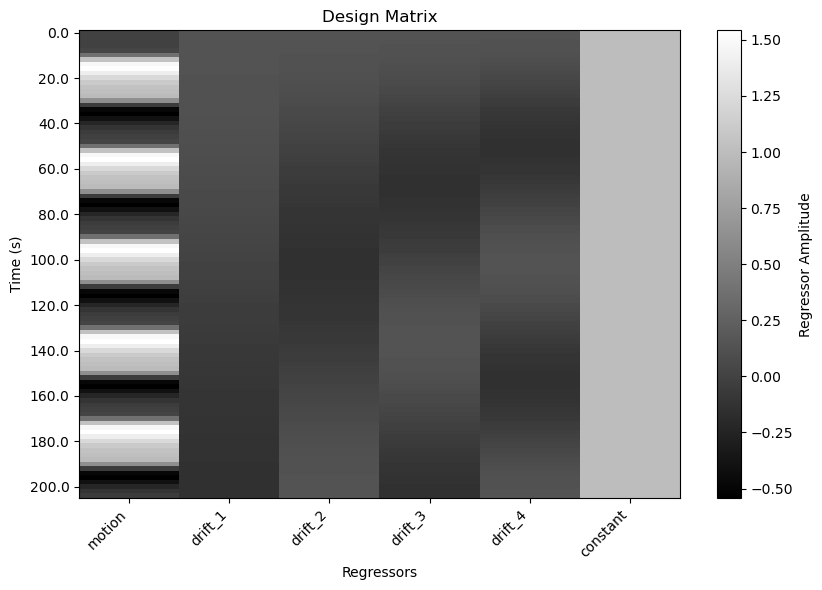

In [16]:
# plot design matrix, in grey scale
plt.figure(figsize=(8.5, 6))
plt.imshow(design_matrix, aspect='auto', cmap='gray', interpolation='nearest')
plt.colorbar(label='Regressor Amplitude')
plt.yticks(ticks=np.arange(0, design_matrix.shape[0], step=10),
           labels=np.arange(0, design_matrix.shape[0], step=10) * voxel_dimensions[3])
plt.xticks(ticks=np.arange(design_matrix.shape[1]),
           labels=design_matrix.columns, rotation=45, ha='right')
plt.xlabel('Regressors')
plt.ylabel('Time (s)')
plt.title('Design Matrix')      
plt.tight_layout()
plt.show()

### Plot design matrix with `Nilearn`

`Nilearn` also provides a convenient function to plot the design matrix directly. 

:::{attention}The main downside to this function is that there is no kwarg to change the colour map. As discused in the chapter on plotting, a greyscale colour map is often better for visualizing matrices like this, since it avoids the perceptual distortions that can arise from using rainbow or other multi-colour maps.
:::

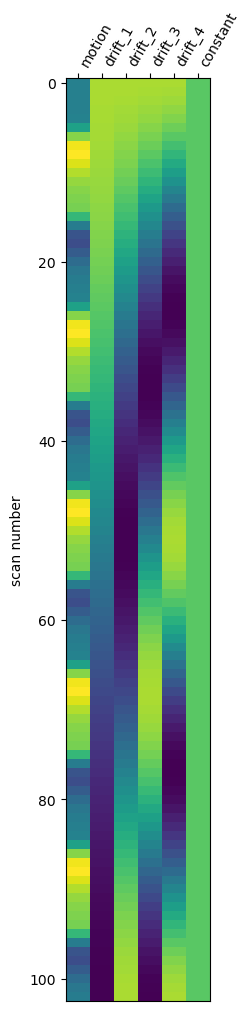

In [ ]:
# plot design matrix using nilearn function
plot_design_matrix(design_matrix)  
plt.show()